# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [5]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [6]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [7]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def centroid_undersampling(data):
    '''Faz o undersampling pegando as amostras do centro do cluster
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    centrounder = ClusterCentroids(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = centrounder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = centrounder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [8]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [9]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = centroid_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [10]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 126, 1.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [12]:
learnRate = 0.01

## RNA 1 (3)

In [21]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso
early_stopping = EarlyStopping(monitor='val_loss',patience=300)
history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

In [45]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.059472224338095972, 0.91386340474985184]


<IPython.core.display.Javascript object>


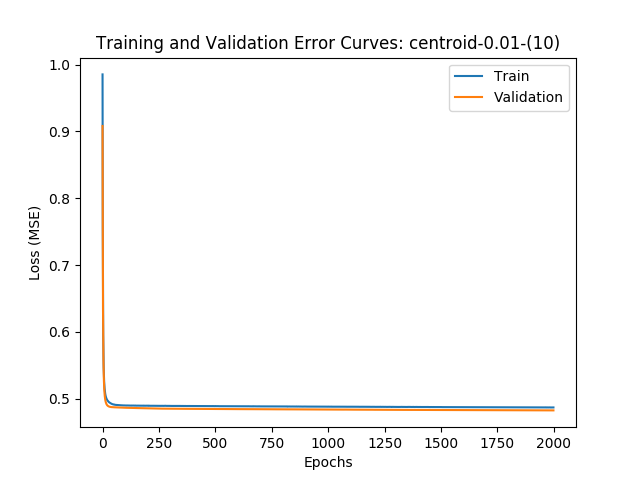

<IPython.core.display.Javascript object>


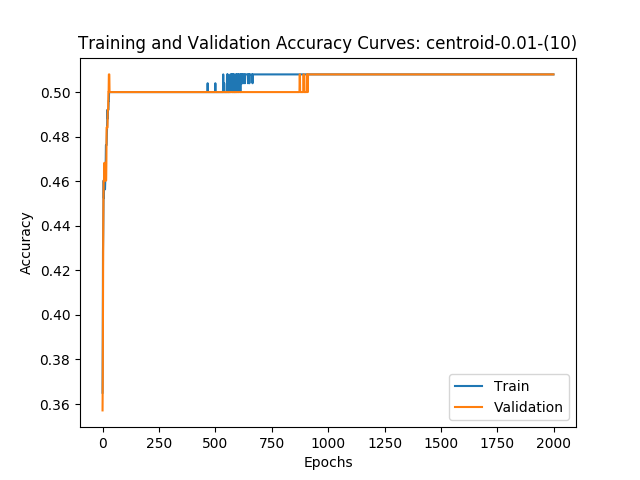

Matriz de confusão
[[1897    1]
 [  64    0]]

Train Loss:       0.4869
Validation Loss:  0.4825
Accuracy:         0.9669
MSE:              0.0331
AUROC:            0.3756


In [22]:
plot_training_error_curves(history, "centroid-0.01-(10)")
plot_training_acc_curves(history, "centroid-0.01-(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (5)

In [37]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss',patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

In [25]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.082491474565988168, 0.88888888882812978]


<IPython.core.display.Javascript object>


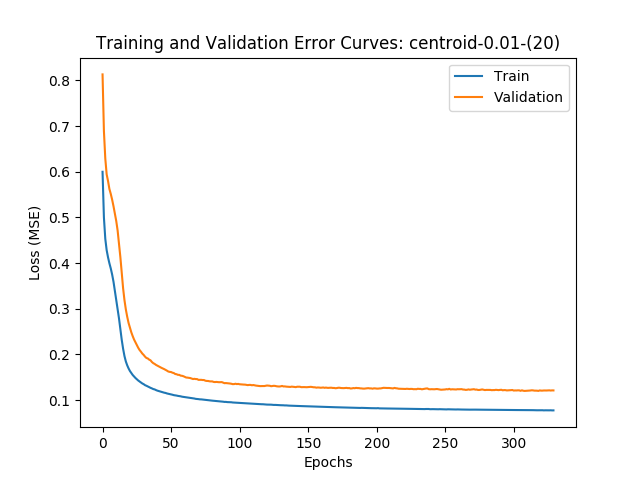

<IPython.core.display.Javascript object>


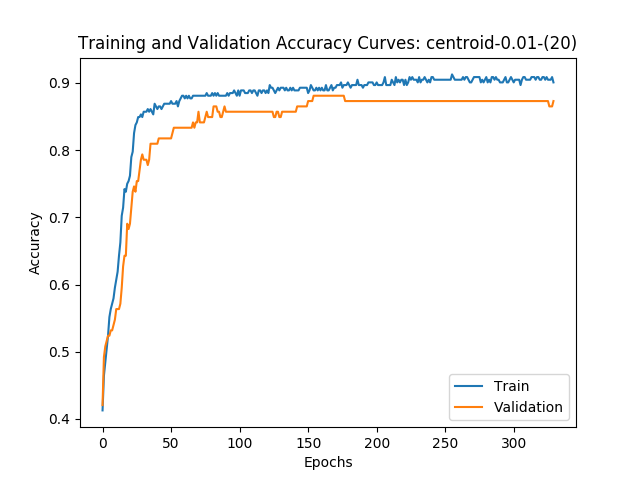

Matriz de confusão
[[1709  189]
 [   7   57]]

Train Loss:       0.0780
Validation Loss:  0.1201
Accuracy:         0.9001
MSE:              0.0999
AUROC:            0.9609


In [38]:
plot_training_error_curves(history, "centroid-0.01-(20)")
plot_training_acc_curves(history, "centroid-0.01-(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (3, 5)

In [44]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss',patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

In [28]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1952/1962 [============================>.] - ETA: 0s[0.096767940500582156, 0.90316004083547874]


<IPython.core.display.Javascript object>


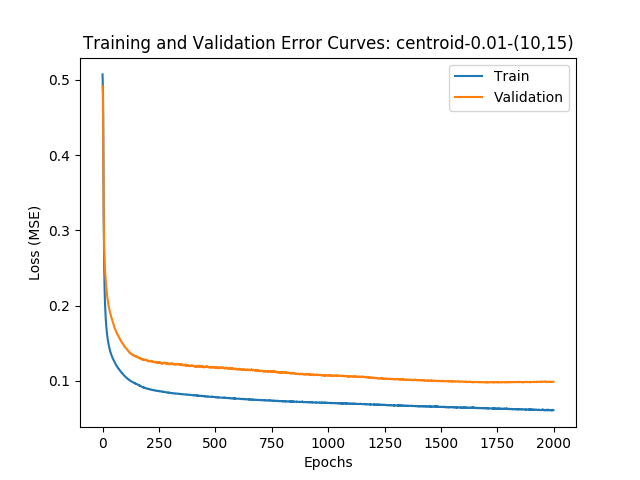

<IPython.core.display.Javascript object>


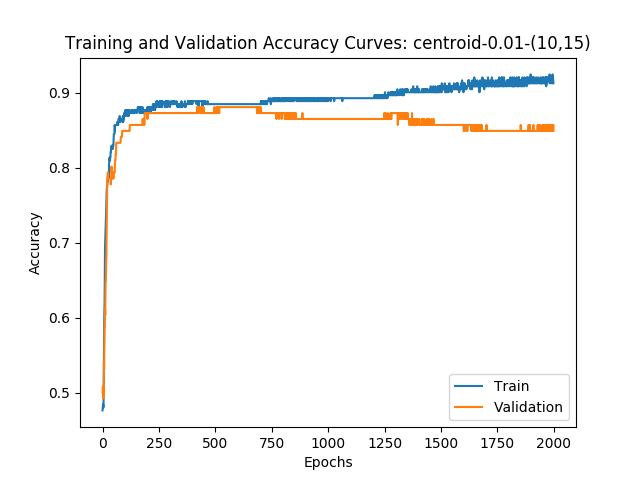

Matriz de confusão
[[1767  131]
 [   7   57]]

Train Loss:       0.0635
Validation Loss:  0.0980
Accuracy:         0.9297
MSE:              0.0703
AUROC:            0.9464


In [45]:
plot_training_error_curves(history, "centroid-0.01-(10,15)")
plot_training_acc_curves(history, "centroid-0.01-(10,15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (5,3)

In [46]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss',patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 1s - loss: 0.4510 - acc: 0.5079 - val_loss: 0.4418 - val_acc: 0.4841
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3977 - acc: 0.5159 - val_loss: 0.3759 - val_acc: 0.4921
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.3118 - acc: 0.5198 - val_loss: 0.2922 - val_acc: 0.5397
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.2286 - acc: 0.6032 - val_loss: 0.2406 - val_acc: 0.6905
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1798 - acc: 0.7222 - val_loss: 0.2198 - val_acc: 0.7381
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1522 - acc: 0.8095 - val_loss: 0.2092 - val_acc: 0.8095
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1367 - acc: 0.8452 - val_loss: 0.2035 - val_acc: 0.8175
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1273 - acc

252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8690 - val_loss: 0.1404 - val_acc: 0.8810
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8690 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8690 - val_loss: 0.1409 - val_acc: 0.8810
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8690 - val_loss: 0.1396 - val_acc: 0.8810
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8690 - val_loss: 0.1387 - val_acc: 0.8651
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8730 - val_loss: 0.1383 - val_acc: 0.8651
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8730 - val_loss: 0.1380 - val_acc: 0.8651
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8730 - val_loss: 0.1382 - val_acc: 0.8651
Epoch 

252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8810 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8810 - val_loss: 0.1274 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8810 - val_loss: 0.1274 - val_acc: 0.8651
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.8810 - val_loss: 0.1265 - val_acc: 0.8651
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.8810 - val_loss: 0.1265 - val_acc: 0.8651
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.8810 - val_loss: 0.1265 - val_acc: 0.8651
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8810 - val_loss: 0.1256 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.8810 - val_loss: 0.1256 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.8810 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.8810 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.8810 - val_loss: 0.1186 - val_acc: 0.8651
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.8810 - val_loss: 0.1191 - val_acc: 0.8651
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.8810 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.8810 - val_loss: 0.1192 - val_acc: 0.8651
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.8810 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.8810 - val_loss: 0.1187 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.8810 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.8810 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - ETA: 0s - loss: 0.0372 - acc: 0.937 - 0s - loss: 0.0763 - acc: 0.8810 - val_loss: 0.1139 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.8810 - val_loss: 0.1134 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.8810 - val_loss: 0.1138 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.8810 - val_loss: 0.1138 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.8810 - val_loss: 0.1139 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.881

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.8889 - val_loss: 0.1122 - val_acc: 0.8730
Epoch 321/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.8889 - val_loss: 0.1128 - val_acc: 0.8730
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.8849 - val_loss: 0.1119 - val_acc: 0.8651
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.8889 - val_loss: 0.1114 - val_acc: 0.8651
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.8889 - val_loss: 0.1118 - val_acc: 0.8651
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.8849 - val_loss: 0.1117 - val_acc: 0.8651
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.8849 - val_loss: 0.1116 - val_acc: 0.8651
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.8889 - val_loss: 0.1122 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.8889 - val_loss: 0.1102 - val_acc: 0.8730
Epoch 385/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.8929 - val_loss: 0.1103 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.8929 - val_loss: 0.1106 - val_acc: 0.8730
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.8889 - val_loss: 0.1103 - val_acc: 0.8730
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.8889 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 389/2000
252/252 [==============================] - ETA: 0s - loss: 0.1161 - acc: 0.812 - 0s - loss: 0.0722 - acc: 0.8889 - val_loss: 0.1100 - val_acc: 0.8730
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.8889 - val_loss: 0.1099 - val_acc: 0.8730
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.892

252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8929 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 449/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.8929 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8968 - val_loss: 0.1074 - val_acc: 0.8730
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8929 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.8929 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1088 - val_acc: 0.8810
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.8929 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1086 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.8968 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 513/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.8968 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8968 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.8968 - val_loss: 0.1072 - val_acc: 0.8810
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.8968 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.8968 - val_loss: 0.1071 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.8968 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9008 - val_loss: 0.1070 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.8968 - val_loss: 0.1053 - val_acc: 0.8810
Epoch 577/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9008 - val_loss: 0.1051 - val_acc: 0.8810
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8810
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9008 - val_loss: 0.1054 - val_acc: 0.8810
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8810
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9008 - val_loss: 0.1055 - val_acc: 0.8730
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.8968 - val_loss: 0.1047 - val_acc: 0.8810
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9008 - val_loss: 0.1050 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9008 - val_loss: 0.1024 - val_acc: 0.8730
Epoch 641/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9008 - val_loss: 0.1026 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9008 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9008 - val_loss: 0.1018 - val_acc: 0.8810
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.8968 - val_loss: 0.1020 - val_acc: 0.8810
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9048 - val_loss: 0.1020 - val_acc: 0.8810
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.8968 - val_loss: 0.1016 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.8968 - val_loss: 0.0982 - val_acc: 0.8730
Epoch 705/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9008 - val_loss: 0.0983 - val_acc: 0.8730
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9008 - val_loss: 0.0980 - val_acc: 0.8810
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.8968 - val_loss: 0.0987 - val_acc: 0.8730
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.8968 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.8968 - val_loss: 0.0977 - val_acc: 0.8730
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.8968 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.8929 - val_loss: 0.0989 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9008 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 769/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.8968 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.8929 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.8968 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.8968 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.8968 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.8968 - val_loss: 0.0950 - val_acc: 0.8968
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.8968 - val_loss: 0.0946 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.8929 - val_loss: 0.0940 - val_acc: 0.8968
Epoch 833/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.8929 - val_loss: 0.0936 - val_acc: 0.8968
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.8929 - val_loss: 0.0938 - val_acc: 0.8968
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.8968 - val_loss: 0.0934 - val_acc: 0.8968
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.8929 - val_loss: 0.0926 - val_acc: 0.8889
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9048 - val_loss: 0.0930 - val_acc: 0.8968
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.8968
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.8968 - val_loss: 0.0928 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9008 - val_loss: 0.0914 - val_acc: 0.8889
Epoch 897/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9048 - val_loss: 0.0912 - val_acc: 0.8889
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9008 - val_loss: 0.0912 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9008 - val_loss: 0.0911 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.8968 - val_loss: 0.0909 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9048 - val_loss: 0.0907 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.8968 - val_loss: 0.0913 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.8968 - val_loss: 0.0913 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9048 - val_loss: 0.0896 - val_acc: 0.8810
Epoch 961/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9048 - val_loss: 0.0900 - val_acc: 0.8889
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9087 - val_loss: 0.0898 - val_acc: 0.8889
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9087 - val_loss: 0.0890 - val_acc: 0.8810
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9048 - val_loss: 0.0893 - val_acc: 0.8810
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9048 - val_loss: 0.0894 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9087 - val_loss: 0.0893 - val_acc: 0.8810
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9087 - val_loss: 0.0892 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9087 - val_loss: 0.0876 - val_acc: 0.8810
Epoch 1024/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9127 - val_loss: 0.0881 - val_acc: 0.8810
Epoch 1025/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9087 - val_loss: 0.0879 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9087 - val_loss: 0.0881 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9087 - val_loss: 0.0878 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9127 - val_loss: 0.0877 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9127 - val_loss: 0.0874 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9087 - val_loss: 0.0877 - val_acc:

252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9127 - val_loss: 0.0867 - val_acc: 0.8810
Epoch 1088/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9167 - val_loss: 0.0868 - val_acc: 0.8810
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9127 - val_loss: 0.0866 - val_acc: 0.8810
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9127 - val_loss: 0.0868 - val_acc: 0.8810
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9087 - val_loss: 0.0868 - val_acc: 0.8810
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9127 - val_loss: 0.0868 - val_acc: 0.8810
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9087 - val_loss: 0.0869 - val_acc: 0.8810
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9127 - val_loss: 0.0869 - val_acc:

252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9087 - val_loss: 0.0858 - val_acc: 0.8810
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9167 - val_loss: 0.0859 - val_acc: 0.8810
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9167 - val_loss: 0.0861 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9127 - val_loss: 0.0858 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9167 - val_loss: 0.0858 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9127 - val_loss: 0.0857 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9206 - val_loss: 0.0857 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9206 - val_loss: 0.0855 - val_acc:

252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9246 - val_loss: 0.0844 - val_acc: 0.8889
Epoch 1216/2000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9246 - val_loss: 0.0847 - val_acc: 0.8889
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9246 - val_loss: 0.0850 - val_acc: 0.8810
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9246 - val_loss: 0.0845 - val_acc: 0.8889
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0558 - acc: 0.9167 - val_loss: 0.0845 - val_acc: 0.8889
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9206 - val_loss: 0.0844 - val_acc: 0.8889
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.0842 - val_acc: 0.8810
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9246 - val_loss: 0.0847 - val_acc:

252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9246 - val_loss: 0.0832 - val_acc: 0.8889
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9246 - val_loss: 0.0831 - val_acc: 0.8889
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9206 - val_loss: 0.0831 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9246 - val_loss: 0.0829 - val_acc: 0.8889
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9246 - val_loss: 0.0833 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9246 - val_loss: 0.0833 - val_acc: 0.8889
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9206 - val_loss: 0.0832 - val_acc: 0.8889
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9206 - val_loss: 0.0828 - val_acc:

252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9206 - val_loss: 0.0821 - val_acc: 0.8968
Epoch 1343/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9246 - val_loss: 0.0825 - val_acc: 0.8889
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9206 - val_loss: 0.0823 - val_acc: 0.8968
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9206 - val_loss: 0.0822 - val_acc: 0.9048
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0539 - acc: 0.9246 - val_loss: 0.0824 - val_acc: 0.8968
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9246 - val_loss: 0.0821 - val_acc: 0.8968
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9167 - val_loss: 0.0822 - val_acc: 0.8968
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9206 - val_loss: 0.0819 - val_acc:

252/252 [==============================] - 0s - loss: 0.0529 - acc: 0.9206 - val_loss: 0.0805 - val_acc: 0.8889
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0525 - acc: 0.9286 - val_loss: 0.0808 - val_acc: 0.8889
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0525 - acc: 0.9246 - val_loss: 0.0805 - val_acc: 0.8968
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0525 - acc: 0.9206 - val_loss: 0.0808 - val_acc: 0.8968
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9206 - val_loss: 0.0807 - val_acc: 0.8889
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0526 - acc: 0.9206 - val_loss: 0.0810 - val_acc: 0.8889
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9246 - val_loss: 0.0810 - val_acc: 0.8889
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9246 - val_loss: 0.0812 - val_acc:

252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9246 - val_loss: 0.0801 - val_acc: 0.9048
Epoch 1470/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9246 - val_loss: 0.0798 - val_acc: 0.8968
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9246 - val_loss: 0.0800 - val_acc: 0.8889
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9246 - val_loss: 0.0798 - val_acc: 0.8889
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9246 - val_loss: 0.0799 - val_acc: 0.8968
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9286 - val_loss: 0.0800 - val_acc: 0.8968
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0521 - acc: 0.9246 - val_loss: 0.0799 - val_acc: 0.8968
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9286 - val_loss: 0.0799 - val_acc:

252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9286 - val_loss: 0.0792 - val_acc: 0.8968
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9325 - val_loss: 0.0788 - val_acc: 0.9048
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0509 - acc: 0.9246 - val_loss: 0.0789 - val_acc: 0.8968
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9325 - val_loss: 0.0789 - val_acc: 0.8968
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9246 - val_loss: 0.0789 - val_acc: 0.8968
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9286 - val_loss: 0.0789 - val_acc: 0.8968
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9286 - val_loss: 0.0791 - val_acc: 0.9048
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0505 - acc: 0.9286 - val_loss: 0.0789 - val_acc:

252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9286 - val_loss: 0.0790 - val_acc: 0.9048
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9286 - val_loss: 0.0789 - val_acc: 0.9048
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0498 - acc: 0.9325 - val_loss: 0.0788 - val_acc: 0.9048
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9286 - val_loss: 0.0789 - val_acc: 0.9048
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9325 - val_loss: 0.0791 - val_acc: 0.9048
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9325 - val_loss: 0.0791 - val_acc: 0.9048
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0497 - acc: 0.9286 - val_loss: 0.0791 - val_acc: 0.8968
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9286 - val_loss: 0.0790 - val_acc:

In [36]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.098454227233011379, 0.88430173286482705]


In [ ]:
plot_training_error_curves(history, "centroid-0.01-(20,10)")
plot_training_acc_curves(history, "centroid-0.01-(20,10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [38]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.3985 - acc: 0.4921 - val_loss: 0.3333 - val_acc: 0.4841
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2788 - acc: 0.5079 - val_loss: 0.2272 - val_acc: 0.6429
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.1879 - acc: 0.7381 - val_loss: 0.1626 - val_acc: 0.7937
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1530 - acc: 0.7976 - val_loss: 0.1481 - val_acc: 0.8095
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1432 - acc: 0.8095 - val_loss: 0.1431 - val_acc: 0.8254
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1331 - acc: 0.8175 - val_loss: 0.1346 - val_acc: 0.8413
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1228 - acc: 0.8373 - val_loss: 0.1329 - val_acc: 0.8333
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1165 - acc

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1531 - val_acc: 0.8889
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1530 - val_acc: 0.8889
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1604 - val_acc: 0.8889
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1549 - val_acc: 0.8889
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1487 - val_acc: 0.8889
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1531 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1559 - val_acc: 0.8889
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1642 - val_acc: 0.8889
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1544 - val_acc: 0.8889
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1529 - val_acc: 0.8810
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1583 - val_acc: 0.8889
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1600 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8889
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1551 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8810 - val_loss: 0.1644 - val_acc: 0.8889
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1534 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8770 - val_loss: 0.1484 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8810 - val_loss: 0.1582 - val_acc: 0.8810
Epoch 450/2000
252/252 [==============================] - ETA: 0s - loss: 0.0996 - acc: 0.906 - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1558 - val_acc: 0.8810
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1585 - val_acc: 0.8889
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1565 - val_acc: 0.8889
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1552 - val_acc: 0.8889
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1537 - val_acc: 0.8810
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.877

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1574 - val_acc: 0.8810
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1521 - val_acc: 0.8810
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8810 - val_loss: 0.1600 - val_acc: 0.8889
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1588 - val_acc: 0.8810
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1566 - val_acc: 0.8810
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1586 - val_acc: 0.8889
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1583 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1576 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8730
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1572 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8849 - val_loss: 0.1580 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8730 - val_loss: 0.1592 - val_acc: 0.8810
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1575 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1548 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1533 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1621 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1528 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1584 - val_acc: 0.8810
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8810 - val_loss: 0.1560 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8849 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1587 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - ETA: 0s - loss: 0.0784 - acc: 0.937 - 0s - loss: 0.0893 - acc: 0.8810 - val_loss: 0.1561 - val_acc: 0.8810
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1594 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1648 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.881

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8810 - val_loss: 0.1528 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1579 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1577 - val_acc: 0.8730
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1591 - val_acc: 0.8889
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1528 - val_acc:

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1601 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8849 - val_loss: 0.1563 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8770 - val_loss: 0.1540 - val_acc: 0.8730
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8770 - val_loss: 0.1562 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1567 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1558 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1555 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1599 - val_acc:

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1516 - val_acc: 0.8730
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1630 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1532 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1559 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1632 - val_acc: 0.8810
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1538 - val_acc:

252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1552 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8770 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8770 - val_loss: 0.1600 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8849 - val_loss: 0.1598 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8770 - val_loss: 0.1549 - val_acc:

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8810 - val_loss: 0.1614 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1593 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1586 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8770 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8849 - val_loss: 0.1563 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1558 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8810 - val_loss: 0.1592 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1587 - val_acc:

252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1618 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1528 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8730 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1638 - val_acc: 0.8889
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1593 - val_acc:

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8849 - val_loss: 0.1561 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1597 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1575 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1526 - val_acc: 0.8810
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1572 - val_acc: 0.8810
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1612 - val_acc:

252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1572 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1569 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1589 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8849 - val_loss: 0.1536 - val_acc: 0.8810
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8849 - val_loss: 0.1593 - val_acc:

In [39]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.079650119691327681, 0.91335372075392929]


<IPython.core.display.Javascript object>


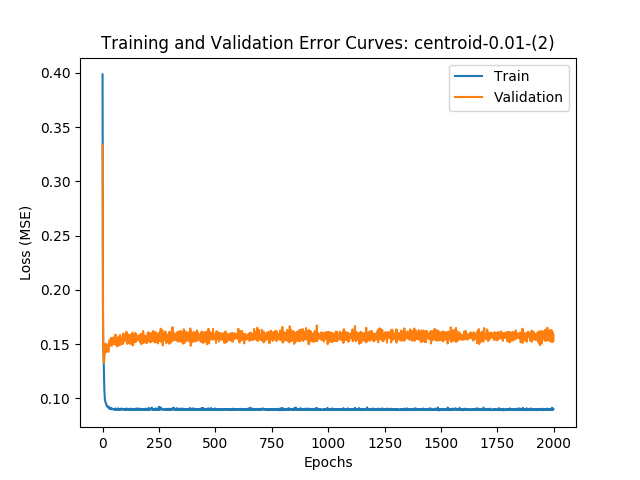

<IPython.core.display.Javascript object>


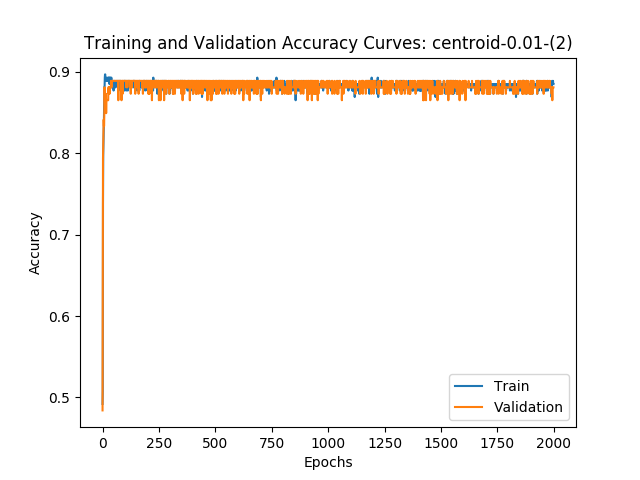

Matriz de confusão
[[1736  162]
 [   7   57]]

Train Loss:       0.1228
Validation Loss:  0.1329
Accuracy:         0.9139
MSE:              0.0861
AUROC:            0.9450


In [40]:
plot_training_error_curves(history, "centroid-0.01-(2)")
plot_training_acc_curves(history, "centroid-0.01-(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [41]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4484 - acc: 0.4683 - val_loss: 0.3372 - val_acc: 0.5635
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2772 - acc: 0.6389 - val_loss: 0.2569 - val_acc: 0.6984
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2030 - acc: 0.7381 - val_loss: 0.1945 - val_acc: 0.7619
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1571 - acc: 0.7937 - val_loss: 0.1539 - val_acc: 0.8016
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1342 - acc: 0.8294 - val_loss: 0.1293 - val_acc: 0.8413
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1171 - acc: 0.8651 - val_loss: 0.1287 - val_acc: 0.8571
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1082 - acc: 0.8611 - val_loss: 0.1409 - val_acc: 0.8571
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1039 - acc

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.9127
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.0812 - val_acc: 0.9048
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.9127
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.0786 - val_acc: 0.9206
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.0798 - val_acc: 0.9127
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.0782 - val_acc: 0.9206
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9087 - val_loss: 0.0823 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0774 - val_acc: 0.9206
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0865 - val_acc: 0.8968
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0755 - val_acc: 0.9206
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0747 - val_acc: 0.9127
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9087 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9048 - val_loss: 0.0746 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.0853 - val_acc: 0.8968
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9087 - val_loss: 0.0743 - val_acc: 0.9206
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0798 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0759 - val_acc: 0.8968
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0738 - val_acc: 0.9206
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9127 - val_loss: 0.0850 - val_acc: 0.8968
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.0765 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0744 - val_acc: 0.9048
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9127 - val_loss: 0.0797 - val_acc: 0.8968
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0754 - val_acc: 0.9127
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0844 - val_acc: 0.8968
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0754 - val_acc: 0.9206
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9087 - val_loss: 0.0737 - val_acc: 0.9206
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.0852 - val_acc: 0.8889
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9127 - val_loss: 0.0747 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9048 - val_loss: 0.0969 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0745 - val_acc: 0.9127
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9087 - val_loss: 0.0745 - val_acc: 0.9127
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0795 - val_acc: 0.9048
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9127
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0752 - val_acc: 0.9048
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0818 - val_acc: 0.8968
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0745 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.0742 - val_acc: 0.9048
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9048 - val_loss: 0.0835 - val_acc: 0.9048
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0730 - val_acc: 0.9286
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0737 - val_acc: 0.9127
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0797 - val_acc: 0.8968
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9048 - val_loss: 0.0858 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9087 - val_loss: 0.0752 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0772 - val_acc: 0.9127
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9087 - val_loss: 0.0739 - val_acc: 0.9206
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0782 - val_acc: 0.8968
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0763 - val_acc: 0.9127
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0750 - val_acc: 0.9048
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0749 - val_acc: 0.9127
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.0924 - val_acc: 0.8968
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9087 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9127
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0773 - val_acc: 0.9048
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9087 - val_loss: 0.0788 - val_acc: 0.9127
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0742 - val_acc: 0.9206
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.0803 - val_acc: 0.8968
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0743 - val_acc:

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0790 - val_acc: 0.8968
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0731 - val_acc: 0.9206
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0762 - val_acc: 0.9127
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0778 - val_acc: 0.8968
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9087 - val_loss: 0.0734 - val_acc: 0.9206
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0753 - val_acc: 0.9048
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9087 - val_loss: 0.0744 - val_acc:

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0744 - val_acc: 0.9206
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0740 - val_acc: 0.9127
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0762 - val_acc: 0.8968
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0742 - val_acc: 0.9206
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9087 - val_loss: 0.0781 - val_acc: 0.9048
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9087 - val_loss: 0.0763 - val_acc: 0.8968
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.0753 - val_acc:

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0733 - val_acc: 0.9206
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0774 - val_acc: 0.9048
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0767 - val_acc: 0.9048
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9087 - val_loss: 0.0749 - val_acc: 0.9048
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9127 - val_loss: 0.0809 - val_acc: 0.8968
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9087 - val_loss: 0.0760 - val_acc: 0.9048
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9087 - val_loss: 0.0758 - val_acc: 0.9127
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9087 - val_loss: 0.0835 - val_acc:

252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9127 - val_loss: 0.0753 - val_acc: 0.9206
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0760 - val_acc: 0.9048
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9127 - val_loss: 0.0735 - val_acc: 0.9127
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9127 - val_loss: 0.0762 - val_acc: 0.9127
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0798 - val_acc: 0.8968
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9127 - val_loss: 0.0876 - val_acc:

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9087 - val_loss: 0.0806 - val_acc: 0.8968
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0737 - val_acc: 0.9127
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.8968
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9048 - val_loss: 0.0748 - val_acc: 0.9127
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0779 - val_acc: 0.8968
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0751 - val_acc: 0.9127
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.0741 - val_acc: 0.9127
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9087 - val_loss: 0.0760 - val_acc:

252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0740 - val_acc: 0.9206
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0884 - val_acc: 0.8968
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.0732 - val_acc: 0.9206
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0777 - val_acc: 0.9048
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9048 - val_loss: 0.0758 - val_acc: 0.9127
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.0819 - val_acc: 0.8968
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0764 - val_acc: 0.9048
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9127 - val_loss: 0.0731 - val_acc:

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0744 - val_acc: 0.9206
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9048
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9127 - val_loss: 0.0770 - val_acc: 0.9048
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0758 - val_acc: 0.9206
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9087 - val_loss: 0.0759 - val_acc: 0.9048
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9087 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0775 - val_acc: 0.8968
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.0737 - val_acc:

In [42]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096324953433813545, 0.89500509677920015]


<IPython.core.display.Javascript object>


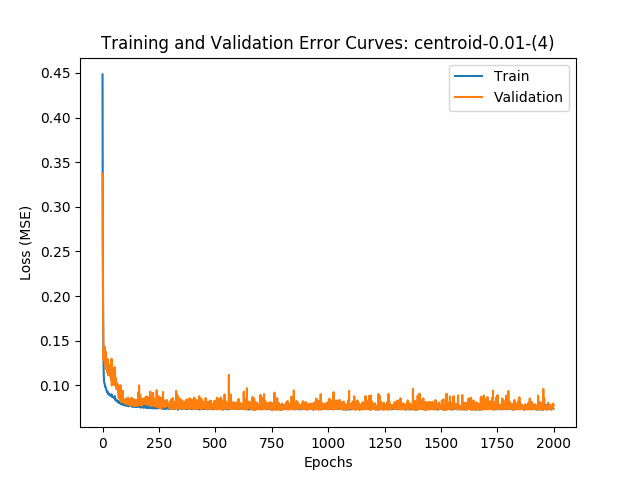

<IPython.core.display.Javascript object>


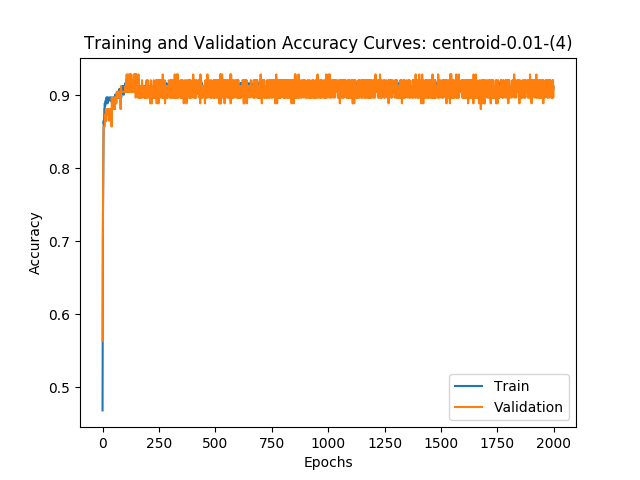

Matriz de confusão
[[1700  198]
 [   8   56]]

Train Loss:       0.0745
Validation Loss:  0.0719
Accuracy:         0.8950
MSE:              0.1050
AUROC:            0.9276


In [43]:
plot_training_error_curves(history, "centroid-0.01-(4)")
plot_training_acc_curves(history, "centroid-0.01-(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))